To reproduce this experiment, the following commands need to be run:

```shell
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=afl fed="mnist_$i" task="mnist"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=afl fed="mnist_all_$i" task="mnist"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=fedavg fed="mnist_$i" task="mnist"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=fedavg fed="mnist_all_$i" task="mnist"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=afl fed="mnist_$i" task="mnist_low_lr"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=fedavg fed="mnist_$i" task="mnist_low_lr_no_scheduler"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=fedadam fed="mnist_$i" task="mnist_low_lr_no_scheduler"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=fedadagrad fed="mnist_$i" task="mnist_low_lr_no_scheduler"; done
```

The results of the runs should be renamed on wandb in this order:
1. f"afl_{i}_compare_bugfree_high_lr" - e.g. afl_5_compare_bugfree_high_lr
2. f"afl_{i}_lr_schedule_all"
3. f"fedavg_{i}_compare_high_lr"
4. f"fedavg_{i}_lr_schedule_all"
5. f"afl_{i}_compare"
6. f"fedavg_{i}_compare"
7. f"fedadam_{i}_compare"
8. f"fedadagrad_{i}_compare"

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import wandb
from pathlib import Path
from plotting.wandb_utils import get_filtered_runs

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [
    "Times New Roman",
] + plt.rcParams["font.serif"]
sns.set_style("whitegrid")
CB_color_cycle = [
    "#377EB8",
    "#FF7F00",
    "#4DAF4A",
    "#F781BF",
    "#A65628",
    "#984EA3",
    "#999999",
    "#E41A1C",
    "#DEDE00",
]

We get the data from Weights and Biases for all of the runs of interest.

In [21]:
api = wandb.Api()
entity, project = "kornelszabo", "template"

In [37]:
artifacts = get_filtered_runs(
    lambda run: ("compare" == run.name.split("_")[-1]),
    api=api,
    entity=entity,
    project=project,
)

train_1 = pd.DataFrame(
    np.array([v.train_accuracy.values[:31] for v in artifacts.values()]).T,
    columns=[f"{name.split('_')[0]}_2e-5" for name in artifacts],
)

test_1 = pd.DataFrame(
    np.array([v.test_accuracy.values[:31] for v in artifacts.values()]).T,
    columns=[f"{name.split('_')[0]}_2e-5" for name in artifacts],
)

artifacts = get_filtered_runs(
    lambda run: ("compare" in run.name and "high_lr" in run.name),
    api=api,
    entity=entity,
    project=project,
)
train_2 = pd.DataFrame(
    np.array([v.train_accuracy.values[:31] for v in artifacts.values()]).T,
    columns=[f"{name.split('_')[0]}_6e-5" for name in artifacts],
)

test_2 = pd.DataFrame(
    np.array([v.test_accuracy.values[:31] for v in artifacts.values()]).T,
    columns=[f"{name.split('_')[0]}_6e-5" for name in artifacts],
)


artifacts = get_filtered_runs(
    lambda run: ("lr_schedule_all" in run.name), api=api, entity=entity, project=project
)
train_3 = pd.DataFrame(
    np.array([v.train_accuracy.values[:31] for v in artifacts.values()]).T,
    columns=[f"{name.split('_')[0]}_all" for name in artifacts],
)

test_3 = pd.DataFrame(
    np.array([v.test_accuracy.values[:31] for v in artifacts.values()]).T,
    columns=[f"{name.split('_')[0]}_all" for name in artifacts],
)

We parse the data into appropriate format and plot the accuracies.

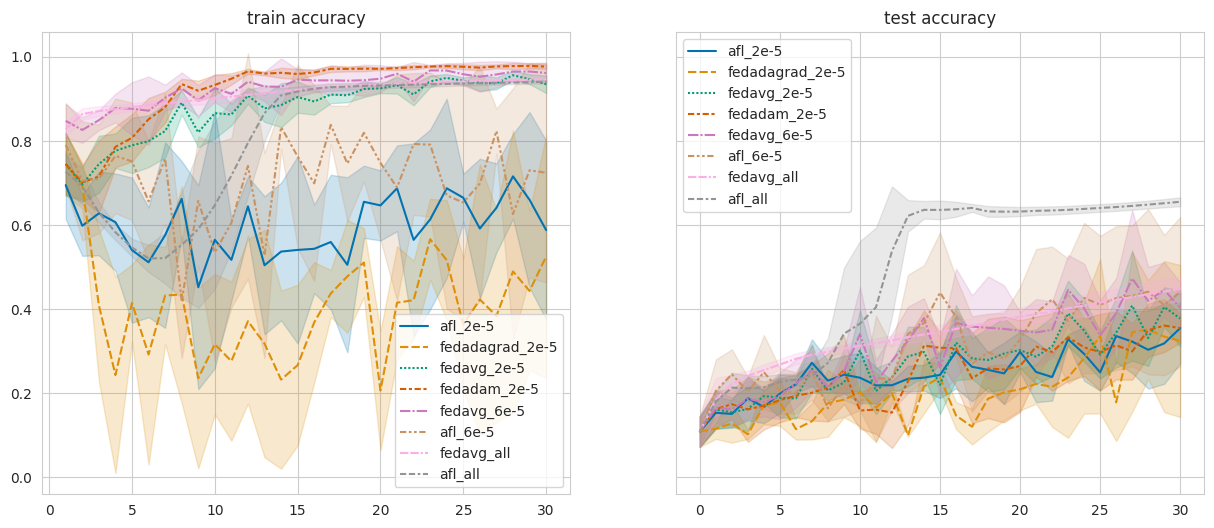

In [38]:
train = pd.concat([train_1, train_2, train_3], axis=1)

test = pd.concat([test_1, test_2, test_3], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.lineplot(train, errorbar="sd", palette="colorblind", ax=ax[0]).set_title(
    "train accuracy"
)
sns.lineplot(test, errorbar="sd", palette="colorblind", ax=ax[1]).set_title(
    "test accuracy"
)
#
#
plt.savefig("./plots/exp_2.png", bbox_inches="tight")

We run Welch's t-test on the test accuracies at the last epoch.

In [42]:
data = test.iloc[-1].rename("test_acc")
table = data.reset_index().groupby("index").test_acc.agg(["mean", "std"])
table = table.loc[[
    "afl_2e-5",
    "fedavg_2e-5",
    "fedadam_2e-5",
    "fedadagrad_2e-5",
    "afl_6e-5",
    "fedavg_6e-5",
    "afl_all",
    "fedavg_all",
]]
print(table.T.to_latex(float_format="%.2f"))
list_data = data.reset_index().groupby("index").agg(list)

\begin{tabular}{lrrrrrrrr}
\toprule
index & afl_2e-5 & fedavg_2e-5 & fedadam_2e-5 & fedadagrad_2e-5 & afl_6e-5 & fedavg_6e-5 & afl_all & fedavg_all \\
\midrule
mean & 0.35 & 0.38 & 0.35 & 0.32 & 0.44 & 0.40 & 0.66 & 0.45 \\
std & 0.09 & 0.07 & 0.04 & 0.20 & 0.19 & 0.07 & 0.01 & 0.03 \\
\bottomrule
\end{tabular}



In [45]:
print("AFL vs baseline for lr = 2e-5")
for model in ["fedavg", "fedadam", "fedadagrad"]:
    statistic = scipy.stats.ttest_ind(
        list_data.loc["afl_2e-5"].test_acc, list_data.loc[f"{model}_2e-5"].test_acc
    )
    print(
        f"""{model}:
    p-value: {statistic.pvalue},
    statistic: {statistic.statistic}
"""
    )

print("AFL vs baseline for lr = 6e-5")
for model in ["fedavg"]:
    statistic = scipy.stats.ttest_ind(
        list_data.loc["afl_6e-5"].test_acc, list_data.loc[f"{model}_2e-5"].test_acc
    )
    print(
        f"""{model}:
    p-value: {statistic.pvalue},
    statistic: {statistic.statistic}
"""
    )

print("AFL vs baseline for clients_per_round=10")
for model in ["fedavg"]:
    statistic = scipy.stats.ttest_ind(
        list_data.loc["afl_all"].test_acc, list_data.loc[f"{model}_all"].test_acc
    )
    print(
        f"""{model}:
    p-value: {statistic.pvalue},
    statistic: {statistic.statistic}
"""
    )

AFL vs baseline for lr = 2e-5
fedavg:
    p-value: 0.6743908866597954,
    statistic: -0.43595970654213523

fedadam:
    p-value: 0.9999878964277736,
    statistic: -1.564986148247941e-05

fedadagrad:
    p-value: 0.7620026967802909,
    statistic: 0.31338549843574537

AFL vs baseline for lr = 6e-5
fedavg:
    p-value: 0.5141775903828332,
    statistic: 0.6825302894759037

AFL vs baseline for clients_per_round=10
fedavg:
    p-value: 8.389836210689609e-07,
    statistic: 13.563156212027469

